# Method 3 - Best Minus Rest Top 3

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Calculate Intra-Portfolio Cap Weight

valid_data['weight'] = valid_data['market_cap_val_cur'] / valid_data.groupby(
    ['datadate', 'institution_id'])['market_cap_val_cur'].transform('sum')

# Calculate Intra-Portfolio Cap Weight Tilt

valid_data['adj_target'] = valid_data['target'] - valid_data['weight'].fillna(0)

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)
                                                                                         
# Split Long and Short and Filter to Highest Tilts

long_ideas = valid_data[valid_data['pos_rank'] <= 3].copy()                                                                    
short_ideas = valid_data[valid_data['pos_rank'] > 3].copy()

# Weight the best ideas

long_ideas['target'] = long_ideas['target'] / long_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / long_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

short_ideas['target'] = - short_ideas['target'] / short_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / short_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

best_ideas = pd.concat([long_ideas, short_ideas])

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return.name = 'port_return'

## Plot Performance

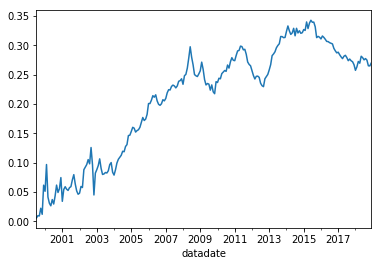

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.061606
2000-12-31    0.012179
2001-12-31   -0.026413
2002-12-31    0.034471
2003-12-31    0.001354
2004-12-31    0.058160
2005-12-31    0.030990
2006-12-31    0.019492
2007-12-31    0.031181
2008-12-31    0.006745
2009-12-31   -0.010596
2010-12-31    0.029403
2011-12-31   -0.007370
2012-12-31   -0.011606
2013-12-31    0.050392
2014-12-31    0.006145
2015-12-31   -0.005825
2016-12-31   -0.020300
2017-12-31   -0.015631
2018-12-31    0.002211
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.329
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     28.05
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.75e-19
Time:                        13:40:19   Log-Likelihood:                 790.05
No. Observations:                 234   AIC:                            -1570.
Df Residuals:                     229   BIC:                            -1553.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.001      0.510      0.611      -0.001       0.001
mktrf         -0.0366      0.016     -2.351      0.020      -0.067      -0.006
me             0.1700      0.018      9.376      0.000       0.134       0.206
ia            -0.0947      0.028     -3.435      0.001      -0.149      -0.040
roe            0.1248      0.024      5.291      0.000       0.078       0.171
==============================================================================
Omnibus:                       40.465   Durbin-Watson:                   2.285
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              397.665
Skew:                          -0.089   Prob(JB):                     4.45e-87
Kurtosis:                       9.384   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.329
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     12.34
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.19e-09
Time:                        13:40:19   Log-Likelihood:                 790.05
No. Observations:                 234   AIC:                            -1570.
Df Residuals:                     229   BIC:                            -1553.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.001      0.499      0.618      -0.001       0.001
mktrf         -0.0366      0.021     -1.758      0.079      -0.077       0.004
me             0.1700      0.027      6.257      0.000       0.117       0.223
ia            -0.0947      0.058     -1.623      0.105      -0.209       0.020
roe            0.1248      0.047      2.675      0.007       0.033       0.216
==============================================================================
Omnibus:                       40.465   Durbin-Watson:                   2.285
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              397.665
Skew:                          -0.089   Prob(JB):                     4.45e-87
Kurtosis:                       9.384   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.329
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     11.81
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.78e-09
Time:                        13:40:19   Log-Likelihood:                 790.05
No. Observations:                 234   AIC:                            -1570.
Df Residuals:                     229   BIC:                            -1553.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.001      0.462      0.644      -0.001       0.002
mktrf         -0.0366      0.019     -1.973      0.049      -0.073      -0.000
me             0.1700      0.026      6.499      0.000       0.119       0.221
ia            -0.0947      0.055     -1.736      0.083      -0.202       0.012
roe            0.1248      0.048      2.619      0.009       0.031       0.218
==============================================================================
Omnibus:                       40.465   Durbin-Watson:                   2.285
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              397.665
Skew:                          -0.089   Prob(JB):                     4.45e-87
Kurtosis:                       9.384   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     14.74
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.58e-12
Time:                        13:40:19   Log-Likelihood:                 776.18
No. Observations:                 234   AIC:                            -1540.
Df Residuals:                     228   BIC:                            -1520.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.001      1.088      0.278      -0.001       0.002
mktrf         -0.0570      0.017     -3.429      0.001      -0.090      -0.024
smb            0.1620      0.022      7.389      0.000       0.119       0.205
hml           -0.0541      0.026     -2.095      0.037      -0.105      -0.003
rmw            0.0682      0.029      2.335      0.020       0.011       0.126
cma           -0.0130      0.037     -0.350      0.727      -0.086       0.060
==============================================================================
Omnibus:                       57.370   Durbin-Watson:                   2.407
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              662.673
Skew:                          -0.522   Prob(JB):                    1.27e-144
Kurtosis:                      11.178   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     11.09
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.42e-09
Time:                        13:40:19   Log-Likelihood:                 776.18
No. Observations:                 234   AIC:                            -1540.
Df Residuals:                     228   BIC:                            -1520.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.001      1.039      0.299      -0.001       0.002
mktrf         -0.0570      0.022     -2.591      0.010      -0.100      -0.014
smb            0.1620      0.038      4.221      0.000       0.087       0.237
hml           -0.0541      0.032     -1.671      0.095      -0.118       0.009
rmw            0.0682      0.061      1.112      0.266      -0.052       0.189
cma           -0.0130      0.103     -0.126      0.899      -0.215       0.189
==============================================================================
Omnibus:                       57.370   Durbin-Watson:                   2.407
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              662.673
Skew:                          -0.522   Prob(JB):                    1.27e-144
Kurtosis:                      11.178   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     13.61
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.25e-11
Time:                        13:40:19   Log-Likelihood:                 776.18
No. Observations:                 234   AIC:                            -1540.
Df Residuals:                     228   BIC:                            -1520.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.001      0.978      0.328      -0.001       0.002
mktrf         -0.0570      0.021     -2.743      0.006      -0.098      -0.016
smb            0.1620      0.034      4.728      0.000       0.095       0.229
hml           -0.0541      0.034     -1.598      0.110      -0.121       0.012
rmw            0.0682      0.067      1.014      0.311      -0.064       0.200
cma           -0.0130      0.108     -0.120      0.904      -0.224       0.198
==============================================================================
Omnibus:                       57.370   Durbin-Watson:                   2.407
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              662.673
Skew:                          -0.522   Prob(JB):                    1.27e-144
Kurtosis:                      11.178   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.520
Method:                 Least Squares   F-statistic:                     64.14
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.60e-36
Time:                        13:40:19   Log-Likelihood:                 831.34
No. Observations:                 234   AIC:                            -1653.
Df Residuals:                     229   BIC:                            -1635.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      0.597      0.551      -0.001       0.001
mktrf         -0.0116      0.012     -0.966      0.335      -0.035       0.012
smb            0.0873      0.015      5.813      0.000       0.058       0.117
hml            0.0183      0.015      1.227      0.221      -0.011       0.048
umd            0.1199      0.010     12.249      0.000       0.101       0.139
==============================================================================
Omnibus:                       32.008   Durbin-Watson:                   2.145
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              144.816
Skew:                          -0.370   Prob(JB):                     3.58e-32
Kurtosis:                       6.782   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.520
Method:                 Least Squares   F-statistic:                     29.36
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.04e-19
Time:                        13:40:19   Log-Likelihood:                 831.34
No. Observations:                 234   AIC:                            -1653.
Df Residuals:                     229   BIC:                            -1635.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.001      0.553      0.580      -0.001       0.001
mktrf         -0.0116      0.018     -0.653      0.514      -0.047       0.023
smb            0.0873      0.020      4.427      0.000       0.049       0.126
hml            0.0183      0.015      1.215      0.224      -0.011       0.048
umd            0.1199      0.021      5.615      0.000       0.078       0.162
==============================================================================
Omnibus:                       32.008   Durbin-Watson:                   2.145
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              144.816
Skew:                          -0.370   Prob(JB):                     3.58e-32
Kurtosis:                       6.782   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.520
Method:                 Least Squares   F-statistic:                     41.49
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.85e-26
Time:                        13:40:19   Log-Likelihood:                 831.34
No. Observations:                 234   AIC:                            -1653.
Df Residuals:                     229   BIC:                            -1635.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.001      0.518      0.605      -0.001       0.001
mktrf         -0.0116      0.017     -0.692      0.489      -0.045       0.021
smb            0.0873      0.018      4.840      0.000       0.052       0.123
hml            0.0183      0.012      1.482      0.138      -0.006       0.043
umd            0.1199      0.023      5.198      0.000       0.075       0.165
==============================================================================
Omnibus:                       32.008   Durbin-Watson:                   2.145
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              144.816
Skew:                          -0.370   Prob(JB):                     3.58e-32
Kurtosis:                       6.782   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.404
Model:                            OLS   Adj. R-squared:                  0.383
Method:                 Least Squares   F-statistic:                     19.48
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.92e-12
Time:                        13:40:19   Log-Likelihood:                 381.52
No. Observations:                 120   AIC:                            -753.0
Df Residuals:                     115   BIC:                            -739.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7.802e-05      0.001     -0.079      0.937      -0.002       0.002
mktrf         -0.0098      0.027     -0.371      0.711      -0.062       0.043
me             0.1910      0.026      7.295      0.000       0.139       0.243
ia            -0.1331      0.041     -3.245      0.002      -0.214      -0.052
roe            0.1982      0.036      5.462      0.000       0.126       0.270
==============================================================================
Omnibus:                       18.861   Durbin-Watson:                   2.363
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               92.380
Skew:                          -0.115   Prob(JB):                     8.71e-21
Kurtosis:                       7.292   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.404
Model:                            OLS   Adj. R-squared:                  0.383
Method:                 Least Squares   F-statistic:                     19.14
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.35e-12
Time:                        13:40:19   Log-Likelihood:                 381.52
No. Observations:                 120   AIC:                            -753.0
Df Residuals:                     115   BIC:                            -739.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7.802e-05      0.001     -0.093      0.926      -0.002       0.002
mktrf         -0.0098      0.031     -0.320      0.749      -0.070       0.050
me             0.1910      0.032      5.904      0.000       0.128       0.254
ia            -0.1331      0.073     -1.826      0.068      -0.276       0.010
roe            0.1982      0.054      3.696      0.000       0.093       0.303
==============================================================================
Omnibus:                       18.861   Durbin-Watson:                   2.363
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               92.380
Skew:                          -0.115   Prob(JB):                     8.71e-21
Kurtosis:                       7.292   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.404
Model:                            OLS   Adj. R-squared:                  0.383
Method:                 Least Squares   F-statistic:                     23.91
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.08e-14
Time:                        13:40:19   Log-Likelihood:                 381.52
No. Observations:                 120   AIC:                            -753.0
Df Residuals:                     115   BIC:                            -739.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7.802e-05      0.001     -0.086      0.932      -0.002       0.002
mktrf         -0.0098      0.023     -0.430      0.667      -0.055       0.035
me             0.1910      0.032      5.986      0.000       0.128       0.254
ia            -0.1331      0.069     -1.928      0.054      -0.268       0.002
roe            0.1982      0.046      4.275      0.000       0.107       0.289
==============================================================================
Omnibus:                       18.861   Durbin-Watson:                   2.363
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               92.380
Skew:                          -0.115   Prob(JB):                     8.71e-21
Kurtosis:                       7.292   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.237
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     7.089
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.33e-06
Time:                        13:40:19   Log-Likelihood:                 366.72
No. Observations:                 120   AIC:                            -721.4
Df Residuals:                     114   BIC:                            -704.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.001      0.414      0.680      -0.002       0.003
mktrf         -0.0621      0.032     -1.956      0.053      -0.125       0.001
smb            0.1712      0.036      4.760      0.000       0.100       0.243
hml           -0.0711      0.044     -1.613      0.110      -0.158       0.016
rmw            0.0948      0.052      1.824      0.071      -0.008       0.198
cma           -0.0210      0.057     -0.369      0.713      -0.134       0.092
==============================================================================
Omnibus:                       22.445   Durbin-Watson:                   2.524
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               99.834
Skew:                          -0.411   Prob(JB):                     2.10e-22
Kurtosis:                       7.392   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.237
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     8.522
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.99e-07
Time:                        13:40:19   Log-Likelihood:                 366.72
No. Observations:                 120   AIC:                            -721.4
Df Residuals:                     114   BIC:                            -704.7
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.001      0.435      0.663      -0.002       0.003
mktrf         -0.0621      0.040     -1.557      0.119      -0.140       0.016
smb            0.1712      0.053      3.208      0.001       0.067       0.276
hml           -0.0711      0.037     -1.905      0.057      -0.144       0.002
rmw            0.0948      0.083      1.149      0.250      -0.067       0.257
cma           -0.0210      0.130     -0.162      0.871      -0.275       0.233
==============================================================================
Omnibus:                       22.445   Durbin-Watson:                   2.524
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               99.834
Skew:                          -0.411   Prob(JB):                     2.10e-22
Kurtosis:                       7.392   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.237
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     9.956
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.38e-08
Time:                        13:40:19   Log-Likelihood:                 366.72
No. Observations:                 120   AIC:                            -721.4
Df Residuals:                     114   BIC:                            -704.7
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.001      0.398      0.691      -0.002       0.003
mktrf         -0.0621      0.038     -1.647      0.100      -0.136       0.012
smb            0.1712      0.048      3.561      0.000       0.077       0.265
hml           -0.0711      0.038     -1.893      0.058      -0.145       0.002
rmw            0.0948      0.090      1.053      0.292      -0.082       0.271
cma           -0.0210      0.135     -0.156      0.876      -0.285       0.243
==============================================================================
Omnibus:                       22.445   Durbin-Watson:                   2.524
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               99.834
Skew:                          -0.411   Prob(JB):                     2.10e-22
Kurtosis:                       7.392   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     40.23
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.82e-21
Time:                        13:40:19   Log-Likelihood:                 402.99
No. Observations:                 120   AIC:                            -796.0
Df Residuals:                     115   BIC:                            -782.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.001      0.729      0.468      -0.001       0.002
mktrf          0.0065      0.020      0.333      0.740      -0.032       0.045
smb            0.0610      0.022      2.742      0.007       0.017       0.105
hml            0.0125      0.022      0.561      0.576      -0.032       0.057
umd            0.1398      0.014     10.181      0.000       0.113       0.167
==============================================================================
Omnibus:                       17.010   Durbin-Watson:                   2.216
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.993
Skew:                          -0.497   Prob(JB):                     2.07e-09
Kurtosis:                       5.648   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     19.21
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.01e-12
Time:                        13:40:19   Log-Likelihood:                 402.99
No. Observations:                 120   AIC:                            -796.0
Df Residuals:                     115   BIC:                            -782.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.001      0.795      0.427      -0.001       0.002
mktrf          0.0065      0.026      0.254      0.800      -0.044       0.057
smb            0.0610      0.024      2.508      0.012       0.013       0.109
hml            0.0125      0.015      0.808      0.419      -0.018       0.043
umd            0.1398      0.024      5.777      0.000       0.092       0.187
==============================================================================
Omnibus:                       17.010   Durbin-Watson:                   2.216
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.993
Skew:                          -0.497   Prob(JB):                     2.07e-09
Kurtosis:                       5.648   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     27.28
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.29e-16
Time:                        13:40:19   Log-Likelihood:                 402.99
No. Observations:                 120   AIC:                            -796.0
Df Residuals:                     115   BIC:                            -782.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.001      0.762      0.446      -0.001       0.002
mktrf          0.0065      0.022      0.295      0.768      -0.037       0.050
smb            0.0610      0.018      3.385      0.001       0.026       0.096
hml            0.0125      0.012      1.080      0.280      -0.010       0.035
umd            0.1398      0.024      5.867      0.000       0.093       0.187
==============================================================================
Omnibus:                       17.010   Durbin-Watson:                   2.216
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.993
Skew:                          -0.497   Prob(JB):                     2.07e-09
Kurtosis:                       5.648   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     11.02
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.52e-07
Time:                        13:40:19   Log-Likelihood:                 453.56
No. Observations:                 114   AIC:                            -897.1
Df Residuals:                     109   BIC:                            -883.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.000      1.776      0.079    -9.5e-05       0.002
mktrf         -0.0518      0.014     -3.807      0.000      -0.079      -0.025
me             0.1162      0.021      5.530      0.000       0.075       0.158
ia            -0.0540      0.029     -1.852      0.067      -0.112       0.004
roe           -0.0457      0.026     -1.786      0.077      -0.097       0.005
==============================================================================
Omnibus:                        3.580   Durbin-Watson:                   1.818
Prob(Omnibus):                  0.167   Jarque-Bera (JB):                3.270
Skew:                           0.414   Prob(JB):                        0.195
Kurtosis:                       3.046   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     13.06
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.01e-08
Time:                        13:40:19   Log-Likelihood:                 453.56
No. Observations:                 114   AIC:                            -897.1
Df Residuals:                     109   BIC:                            -883.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      1.356      0.175      -0.000       0.002
mktrf         -0.0518      0.011     -4.512      0.000      -0.074      -0.029
me             0.1162      0.024      4.917      0.000       0.070       0.163
ia            -0.0540      0.031     -1.737      0.082      -0.115       0.007
roe           -0.0457      0.032     -1.425      0.154      -0.109       0.017
==============================================================================
Omnibus:                        3.580   Durbin-Watson:                   1.818
Prob(Omnibus):                  0.167   Jarque-Bera (JB):                3.270
Skew:                           0.414   Prob(JB):                        0.195
Kurtosis:                       3.046   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     14.10
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.64e-09
Time:                        13:40:19   Log-Likelihood:                 453.56
No. Observations:                 114   AIC:                            -897.1
Df Residuals:                     109   BIC:                            -883.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      1.212      0.226      -0.001       0.002
mktrf         -0.0518      0.011     -4.744      0.000      -0.073      -0.030
me             0.1162      0.022      5.201      0.000       0.072       0.160
ia            -0.0540      0.031     -1.754      0.079      -0.114       0.006
roe           -0.0457      0.036     -1.279      0.201      -0.116       0.024
==============================================================================
Omnibus:                        3.580   Durbin-Watson:                   1.818
Prob(Omnibus):                  0.167   Jarque-Bera (JB):                3.270
Skew:                           0.414   Prob(JB):                        0.195
Kurtosis:                       3.046   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                     12.16
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.37e-09
Time:                        13:40:19   Log-Likelihood:                 459.65
No. Observations:                 114   AIC:                            -907.3
Df Residuals:                     108   BIC:                            -890.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.000      1.551      0.124      -0.000       0.002
mktrf         -0.0429      0.012     -3.470      0.001      -0.067      -0.018
smb            0.1366      0.020      6.805      0.000       0.097       0.176
hml           -0.0605      0.026     -2.362      0.020      -0.111      -0.010
rmw           -0.0265      0.031     -0.846      0.400      -0.089       0.036
cma            0.0087      0.040      0.217      0.828      -0.070       0.088
==============================================================================
Omnibus:                        5.335   Durbin-Watson:                   1.819
Prob(Omnibus):                  0.069   Jarque-Bera (JB):                4.738
Skew:                           0.457   Prob(JB):                       0.0936
Kurtosis:                       3.403   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                     26.40
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.41e-17
Time:                        13:40:19   Log-Likelihood:                 459.65
No. Observations:                 114   AIC:                            -907.3
Df Residuals:                     108   BIC:                            -890.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.001      1.203      0.229      -0.000       0.002
mktrf         -0.0429      0.011     -3.807      0.000      -0.065      -0.021
smb            0.1366      0.023      5.990      0.000       0.092       0.181
hml           -0.0605      0.018     -3.434      0.001      -0.095      -0.026
rmw           -0.0265      0.027     -0.985      0.325      -0.079       0.026
cma            0.0087      0.037      0.236      0.814      -0.063       0.081
==============================================================================
Omnibus:                        5.335   Durbin-Watson:                   1.819
Prob(Omnibus):                  0.069   Jarque-Bera (JB):                4.738
Skew:                           0.457   Prob(JB):                       0.0936
Kurtosis:                       3.403   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                     32.26
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.44e-20
Time:                        13:40:19   Log-Likelihood:                 459.65
No. Observations:                 114   AIC:                            -907.3
Df Residuals:                     108   BIC:                            -890.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.001      1.125      0.261      -0.001       0.002
mktrf         -0.0429      0.011     -3.806      0.000      -0.065      -0.021
smb            0.1366      0.022      6.266      0.000       0.094       0.179
hml           -0.0605      0.016     -3.781      0.000      -0.092      -0.029
rmw           -0.0265      0.025     -1.054      0.292      -0.076       0.023
cma            0.0087      0.035      0.245      0.806      -0.060       0.078
==============================================================================
Omnibus:                        5.335   Durbin-Watson:                   1.819
Prob(Omnibus):                  0.069   Jarque-Bera (JB):                4.738
Skew:                           0.457   Prob(JB):                       0.0936
Kurtosis:                       3.403   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.391
Method:                 Least Squares   F-statistic:                     19.16
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.86e-12
Time:                        13:40:19   Log-Likelihood:                 464.55
No. Observations:                 114   AIC:                            -919.1
Df Residuals:                     109   BIC:                            -905.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      1.065      0.289      -0.000       0.001
mktrf         -0.0341      0.012     -2.914      0.004      -0.057      -0.011
smb            0.1391      0.018      7.612      0.000       0.103       0.175
hml           -0.0157      0.019     -0.836      0.405      -0.053       0.022
umd            0.0460      0.014      3.244      0.002       0.018       0.074
==============================================================================
Omnibus:                        5.834   Durbin-Watson:                   1.651
Prob(Omnibus):                  0.054   Jarque-Bera (JB):                5.401
Skew:                           0.521   Prob(JB):                       0.0672
Kurtosis:                       3.225   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.391
Method:                 Least Squares   F-statistic:                     46.56
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.22e-23
Time:                        13:40:19   Log-Likelihood:                 464.55
No. Observations:                 114   AIC:                            -919.1
Df Residuals:                     109   BIC:                            -905.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.001      0.795      0.427      -0.001       0.002
mktrf         -0.0341      0.010     -3.358      0.001      -0.054      -0.014
smb            0.1391      0.018      7.768      0.000       0.104       0.174
hml           -0.0157      0.016     -0.974      0.330      -0.047       0.016
umd            0.0460      0.010      4.488      0.000       0.026       0.066
==============================================================================
Omnibus:                        5.834   Durbin-Watson:                   1.651
Prob(Omnibus):                  0.054   Jarque-Bera (JB):                5.401
Skew:                           0.521   Prob(JB):                       0.0672
Kurtosis:                       3.225   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.391
Method:                 Least Squares   F-statistic:                     68.17
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.70e-29
Time:                        13:40:19   Log-Likelihood:                 464.55
No. Observations:                 114   AIC:                            -919.1
Df Residuals:                     109   BIC:                            -905.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.001      0.755      0.450      -0.001       0.002
mktrf         -0.0341      0.010     -3.513      0.000      -0.053      -0.015
smb            0.1391      0.015      8.981      0.000       0.109       0.169
hml           -0.0157      0.017     -0.942      0.346      -0.048       0.017
umd            0.0460      0.010      4.718      0.000       0.027       0.065
==============================================================================
Omnibus:                        5.834   Durbin-Watson:                   1.651
Prob(Omnibus):                  0.054   Jarque-Bera (JB):                5.401
Skew:                           0.521   Prob(JB):                       0.0672
Kurtosis:                       3.225   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""